# SELFIES

In [ ]:
# load data
import pickle
import tensorflow as tf
import pandas as pd
from tensorflow.data import Dataset
from DGMM_utils import getlabels, get_fp

tf.random.set_seed(358)

train_size = 80000
test_size = 8000
batch_size = 16
pad_to_len = 80

def get_ds(train_data, test_data):
    inp_train = getlabels(train_data['sfi'].values, pad_to_len)
    inp_fp = get_fp(train_data['smiles'])
    train_ds = Dataset.from_tensor_slices((inp_train, inp_fp))
    train_ds = train_ds.batch(batch_size)
    inp_test = getlabels(test_data['sfi'].values, pad_to_len)
    test_fp = get_fp(test_data['smiles'])
    test_ds = Dataset.from_tensor_slices((inp_test, test_fp))
    test_ds = test_ds.batch(batch_size)
    print(f'load train set: {len(train_data)} mols, test set {len(test_data)} mols.')
    return train_ds, test_ds

In [14]:
# df = pd.read_hdf('data/zinc_train_ext.h5')
df = pd.read_hdf('data/zinc_train.h5')

train_df = df[df['split']=='train']
test_df = df[df['split']=='test']

if len(train_df) > train_size:
    train_df = train_df.sample(n=train_size)
if len(test_df) > test_size:
    test_df = test_df.sample(n=test_size)
train_ds, test_ds = get_ds(train_df, test_df)

load train set: 800 mols, test set 800 mols.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from DGMM_utils import TVAE
    
class lrScheduler(keras.callbacks.Callback):
    def __init__(self, ep=2, verbose=0):
        super(lrScheduler, self).__init__()
        self.verbose = verbose
        self.ep = ep

    def on_epoch_begin(self, epoch, logs=None):
        lr = float(keras.backend.get_value(self.model.optimizer.lr))
        ak = float(keras.backend.get_value(self.model.ak))
        if epoch > self.ep:
            lr = lr * tf.math.exp(-0.1)
            if ak > 1e-3:
                ak = 1e-4
            else:
                self.model.ak = ak + 1e-4
            self.model.ak = ak
            keras.backend.set_value(self.model.optimizer.lr, keras.backend.get_value(lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.lr)
        logs['ak'] = keras.backend.get_value(self.model.ak)
        
checkpoint = keras.callbacks.ModelCheckpoint('model/test/DGMM_sfi', monitor='loss', verbose=1, save_best_only=True)
callbacks=[keras.callbacks.TerminateOnNaN(), lrScheduler(), checkpoint]
model = TVAE(pad_to_len, ak=1e-4, lr=1e-3)
model.compile()

In [10]:
his = model.fit(train_ds, validation_data=test_ds, epochs=6, callbacks=callbacks,use_multiprocessing=True, workers=10)

Epoch 1/6
50000/50000 [==============================] - ETA: 0s - loss: 1.1727 - acc: 0.7868 - kl_loss: 234.6801 - fp_loss: 0.2549 - total_loss: 1.6450
Epoch 1: loss improved from inf to 0.92860, saving model to vae/GDMM_1106_sfi
50000/50000 [==============================] - 7971s 159ms/step - loss: 1.1727 - acc: 0.7868 - kl_loss: 234.6801 - fp_loss: 0.2549 - total_loss: 1.6450 - val_loss: 32.0622 - val_fp_loss: 0.2206 - val_acc: 0.8675 - lr: 0.0010 - ak: 1.0000e-04
Epoch 2/6
50000/50000 [==============================] - ETA: 0s - loss: 0.5965 - acc: 0.8850 - kl_loss: 252.7894 - fp_loss: 0.1968 - total_loss: 1.1741
Epoch 2: loss improved from 0.92860 to 0.54948, saving model to vae/GDMM_1106_sfi
50000/50000 [==============================] - 7643s 153ms/step - loss: 0.5965 - acc: 0.8850 - kl_loss: 252.7894 - fp_loss: 0.1968 - total_loss: 1.1741 - val_loss: 21.9893 - val_fp_loss: 0.1846 - val_acc: 0.9081 - lr: 0.0010 - ak: 1.0000e-04
Epoch 3/6
50000/50000 [===========================

In [11]:
his = model.fit(train_ds, validation_data=test_ds, epochs=1, callbacks=callbacks,use_multiprocessing=True, workers=10)

50000/50000 [==============================] - ETA: 0s - loss: 0.2270 - acc: 0.9560 - kl_loss: 260.7519 - fp_loss: 0.1401 - total_loss: 0.6735
Epoch 1: loss improved from 0.24019 to 0.22342, saving model to vae/GDMM_1106_sfi
50000/50000 [==============================] - 7658s 153ms/step - loss: 0.2270 - acc: 0.9560 - kl_loss: 260.7519 - fp_loss: 0.1401 - total_loss: 0.6735 - val_loss: 10.6015 - val_fp_loss: 0.1396 - val_acc: 0.9559 - lr: 7.4082e-04 - ak: 1.0000e-04


In [ ]:
from DGMM_utils import generateTrainDecoder
generateTrainDecoder('model/test/DGMM_sfi_decoder.h5', 'model/test/DGMM_sfi_decoder_nosoftmax.h5', latent_dim=80)

# SELFIES Test

In [111]:
import selfies as sf
import numpy as np
from DGMM_utils import alphabet, chars

def pro2sfi(data):
    res = []
    for s in data:
        sfi = ''
        for j in s:
            idx = np.random.choice(np.arange(len(alphabet)), p=j)
            token = alphabet[idx]
            if alphabet[idx].find("[nop]") > -1:
                break
            sfi+=token
        res.append(sfi)
    return res

def pro2smi(data, attempts=1000):
    res = []
    for y_pred in data:
        atmp = attempts
        while atmp > 0:
            atmp -= 1
            smiles = ''
            for p in y_pred:
                idx = np.random.choice(np.arange(len(chars)+2), p=p)
                if idx == 0 or idx == len(chars)+1:
                    break
                token = chars[idx-1]
                smiles+=token
            try:
                mol = Chem.MolFromSmiles(smiles)
                smiles = Chem.MolToSmiles(mol, canonical=True)
                assert len(smiles) > 1
                res.append(smiles)
                atmp = -1
            except:
                pass
        if atmp != -1:
            res.append('')
    return res

In [38]:
from tensorflow.keras.models import load_model
from DGMM_utils import Sampling
# from keras.models import load_model
encoder = load_model(f'model/TVAE/DGMM_sfi_encoder.h5', custom_objects={'Sampling':Sampling})
decoder = load_model(f'model/TVAE/DGMM_sfi_decoder.h5')

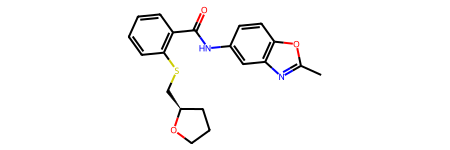

In [49]:
from rdkit import Chem
import pandas as pd
df = pd.read_hdf('data/zinc_train.h5')

sfi = df.sample(n=10)['sfi'].values
Chem.MolFromSmiles(sf.decoder(sfi[0]))

In [50]:
from DGMM_utils import getlabels
label = getlabels(sfi)
latent = encoder.predict(label, verbose=1)
pred = decoder.predict(latent[2], verbose=1)
res = pred[0]

1/1 [==============================] - 0s 67ms/step


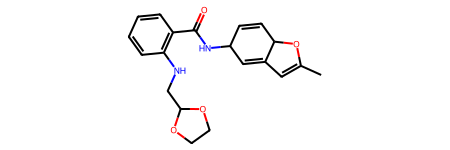

In [51]:
smi = sf.decoder(pro2sfi(res)[0])
Chem.MolFromSmiles(smi)

# SMILES

In [4]:
# load data
import pandas as pd
import tensorflow as tf
from tensorflow.data import Dataset
from DGMM_utils import getslabels, get_fp

tf.random.set_seed(358)

batch_size = 16
train_size = 80000
test_size = 8000
pad_to_len = 80

def get_ds_smi(train_data, test_data):
    inp_train = getslabels(train_data['smiles'].values)
    inp_fp = get_fp(train_data['smiles'])
    train_ds = Dataset.from_tensor_slices((inp_train, inp_fp))
    train_ds = train_ds.batch(batch_size)
    inp_test = getslabels(test_data['smiles'].values)
    test_fp = get_fp(test_data['smiles'])
    test_ds = Dataset.from_tensor_slices((inp_test, test_fp))
    test_ds = test_ds.batch(batch_size)
    print(f'load train set: {len(train_data)} mols, test set {len(test_data)} mols.')
    return train_ds, test_ds

In [ ]:
# df = pd.read_hdf('data/zinc_train_ext.h5')
df = pd.read_hdf('data/zinc_train.h5')

train_df = df[df['split']=='train']
test_df = df[df['split']=='test']
train_df = train_df[train_df['smiles'].str.len()<80]
test_df = test_df[test_df['smiles'].str.len()<80]

if len(train_df) > train_size:
    train_df = train_df.sample(n=train_size)
if len(test_df) > test_size:
    test_df = test_df.sample(n=test_size)
train_ds, test_ds = get_ds_smi(train_df, test_df)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from DGMM_utils import TVAEsmi

    
class lrScheduler(keras.callbacks.Callback):
    def __init__(self, ep=2, verbose=0):
        super(lrScheduler, self).__init__()
        self.verbose = verbose
        self.ep = ep

    def on_epoch_begin(self, epoch, logs=None):
        lr = float(keras.backend.get_value(self.model.optimizer.lr))
        ak = float(keras.backend.get_value(self.model.ak))
        if epoch > self.ep:
            lr = lr * tf.math.exp(-0.1)
            if ak > 1e-3:
                ak = 1e-4
            else:
                self.model.ak = ak + 1e-4
            self.model.ak = ak
            keras.backend.set_value(self.model.optimizer.lr, keras.backend.get_value(lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.lr)
        logs['ak'] = keras.backend.get_value(self.model.ak)

checkpoint = keras.callbacks.ModelCheckpoint('model/test/DGMM_smi', monitor='loss', verbose=1, save_best_only=True)
callbacks=[keras.callbacks.TerminateOnNaN(), lrScheduler(), checkpoint]
model1 = TVAEsmi(pad_to_len, ak=1e-4, lr=1e-3)
model1.compile()

In [67]:
his = model1.fit(train_ds, validation_data=test_ds, epochs=6, callbacks=callbacks,use_multiprocessing=True, workers=10)

Epoch 1/6
49978/49978 [==============================] - ETA: 0s - loss: 0.8835 - acc: 0.7114 - kl_loss: 234.0630 - fp_loss: 0.2376 - total_loss: 1.2011
Epoch 1: loss improved from inf to 0.61015, saving model to vae/GDMM_1106_smi
49978/49978 [==============================] - 7434s 149ms/step - loss: 0.8835 - acc: 0.7114 - kl_loss: 234.0630 - fp_loss: 0.2376 - total_loss: 1.2011 - val_loss: 28.5498 - val_fp_loss: 0.1763 - val_acc: 0.8775 - lr: 0.0010 - ak: 1.0000e-04
Epoch 2/6
49978/49978 [==============================] - ETA: 0s - loss: 0.3186 - acc: 0.8908 - kl_loss: 267.2300 - fp_loss: 0.1558 - total_loss: 0.7597
Epoch 2: loss improved from 0.61015 to 0.29031, saving model to vae/GDMM_1106_smi
49978/49978 [==============================] - 7436s 149ms/step - loss: 0.3186 - acc: 0.8908 - kl_loss: 267.2300 - fp_loss: 0.1558 - total_loss: 0.7597 - val_loss: 20.7614 - val_fp_loss: 0.1448 - val_acc: 0.9126 - lr: 0.0010 - ak: 1.0000e-04
Epoch 3/6
49978/49978 [===========================

In [68]:
his = model1.fit(train_ds, validation_data=test_ds, epochs=2, callbacks=callbacks,use_multiprocessing=True, workers=10)

Epoch 1/2
49978/49978 [==============================] - ETA: 0s - loss: 0.1149 - acc: 0.9618 - kl_loss: 262.2726 - fp_loss: 0.0905 - total_loss: 0.4108
Epoch 1: loss improved from 0.12179 to 0.11299, saving model to vae/GDMM_1106_smi
49978/49978 [==============================] - 7477s 150ms/step - loss: 0.1149 - acc: 0.9618 - kl_loss: 262.2726 - fp_loss: 0.0905 - total_loss: 0.4108 - val_loss: 9.1687 - val_fp_loss: 0.0906 - val_acc: 0.9622 - lr: 7.4082e-04 - ak: 1.0000e-04
Epoch 2/2
49978/49978 [==============================] - ETA: 0s - loss: 0.1078 - acc: 0.9643 - kl_loss: 262.3561 - fp_loss: 0.0873 - total_loss: 0.3859
Epoch 2: loss improved from 0.11299 to 0.10623, saving model to vae/GDMM_1106_smi
49978/49978 [==============================] - 7500s 150ms/step - loss: 0.1078 - acc: 0.9643 - kl_loss: 262.3561 - fp_loss: 0.0873 - total_loss: 0.3859 - val_loss: 8.3492 - val_fp_loss: 0.0898 - val_acc: 0.9656 - lr: 7.4082e-04 - ak: 1.0000e-04


In [69]:
his = model1.fit(train_ds, validation_data=test_ds, epochs=2, callbacks=callbacks,use_multiprocessing=True, workers=10)

Epoch 1/2
49978/49978 [==============================] - ETA: 0s - loss: 0.1025 - acc: 0.9662 - kl_loss: 262.8047 - fp_loss: 0.0849 - total_loss: 0.3659
Epoch 1: loss improved from 0.10623 to 0.10141, saving model to vae/GDMM_1106_smi
49978/49978 [==============================] - 7483s 150ms/step - loss: 0.1025 - acc: 0.9662 - kl_loss: 262.8047 - fp_loss: 0.0849 - total_loss: 0.3659 - val_loss: 8.6184 - val_fp_loss: 0.0865 - val_acc: 0.9652 - lr: 7.4082e-04 - ak: 1.0000e-04
Epoch 2/2
49978/49978 [==============================] - ETA: 0s - loss: 0.0984 - acc: 0.9677 - kl_loss: 262.5767 - fp_loss: 0.0828 - total_loss: 0.3494
Epoch 2: loss improved from 0.10141 to 0.09749, saving model to vae/GDMM_1106_smi
49978/49978 [==============================] - 7738s 155ms/step - loss: 0.0984 - acc: 0.9677 - kl_loss: 262.5767 - fp_loss: 0.0828 - total_loss: 0.3494 - val_loss: 7.3738 - val_fp_loss: 0.0817 - val_acc: 0.9698 - lr: 7.4082e-04 - ak: 1.0000e-04


In [73]:
from tensorflow.keras.models import load_model
from DGMM_utils import Sampling
# from keras.models import load_model
encoder = load_model(f'model/TVAE/DGMM_smi_encoder.h5', custom_objects={'Sampling':Sampling})
decoder = load_model(f'model/TVAE/DGMM_smi_decoder.h5')

# SMILES test

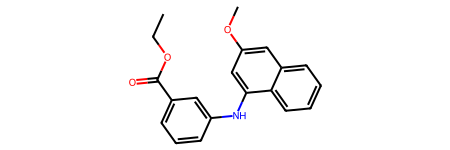

In [116]:
from rdkit import Chem
import pandas as pd
df = pd.read_hdf('data/zinc_train.h5')

smi = df.sample(n=10)['smiles'].values
Chem.MolFromSmiles(smi[0])

In [114]:
from DGMM_utils import getslabels
label = getslabels(smi)
latent = encoder.predict(label, verbose=1)
pred = decoder.predict(latent[2], verbose=1)
res = pred[0]

1/1 [==============================] - 0s 56ms/step


In [115]:
pro2smi(res)

['COCS(=O)c1cccc(Cc2c(OC)ccc3ccccc23)c1',
 'CNOc1cc(Cl)c(NC(=O)NCc2ccc3c(c2)OCO3)c(OOSO)c1Cl',
 'COc1cc(C)c(CCCC(=O)Nc2ccnc(C)n2)c(Cl)c1',
 'C[C@H](Sc1nc(CNCO)no1)C1CCCNCC(c2ccccc2Cl)CCC1',
 '',
 '',
 '',
 'COC1=C(CNCCC=CSc2ccccc2C2C=CC(=O)C(CCc3ccccc3)=C2)C(C)=N1',
 'O=C(N[C@@H]1CCN(c2ncccc2Cl)C1)C1C(Cl)=CN=C1c1cccc(F)c1',
 '']

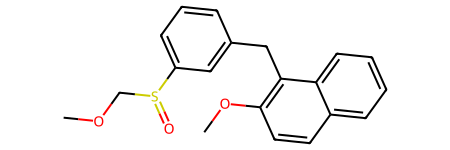

In [117]:
Chem.MolFromSmiles('COCS(=O)c1cccc(Cc2c(OC)ccc3ccccc23)c1')